# CS275P Final Project: Intrusion Detection System Analysis and Prediction

#### Connor McManigal, Aaron Mui, Rishabh Verma, and Peyton Politewicz

## Imports and Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

In [2]:
rt_iot2022 = fetch_ucirepo(id=942) 
x = rt_iot2022.data.features 
y = rt_iot2022.data.targets 

print("Data Shape with Aggregates\n")
print("Rows:", x.shape[0])
print("Features:", x.shape[1])

Data Shape with Aggregates

Rows: 123117
Features: 83


In [3]:
X = x.filter(regex='^((?!max|min|avg|std).)*$')

print("Data Shape without Aggregates\n")
print("Rows:", X.shape[0])
print("Features:", X.shape[1])
X.head()

Data Shape without Aggregates

Rows: 123117
Features: 47


,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.tot,idle.tot,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,0.0,0.0,0.0,0.0,0.0,2282414.913,29729182.96,64240,26847,502
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,0.0,0.0,0.0,0.0,0.0,2028306.961,29855277.06,64240,26847,502
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,0.0,0.0,0.0,0.0,0.0,2281903.982,29842149.02,64240,26847,502
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,0.0,0.0,0.0,0.0,0.0,2047288.179,29913774.97,64240,26847,502
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,0.0,0.0,0.0,0.0,0.0,2087656.975,29814704.90,64240,26847,502


## Exploratory Data Analysis

In [4]:
# get counts of targets
y.value_counts()

Attack_type               
DOS_SYN_Hping                 94659
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

/var/folders/h6/jflqd9l57glcp8j75_d60stm0000gn/T/ipykernel_93349/961355872.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = y, x = y['Attack_type'], order = y['Attack_type'].value_counts().index, palette = 'CMRmap')


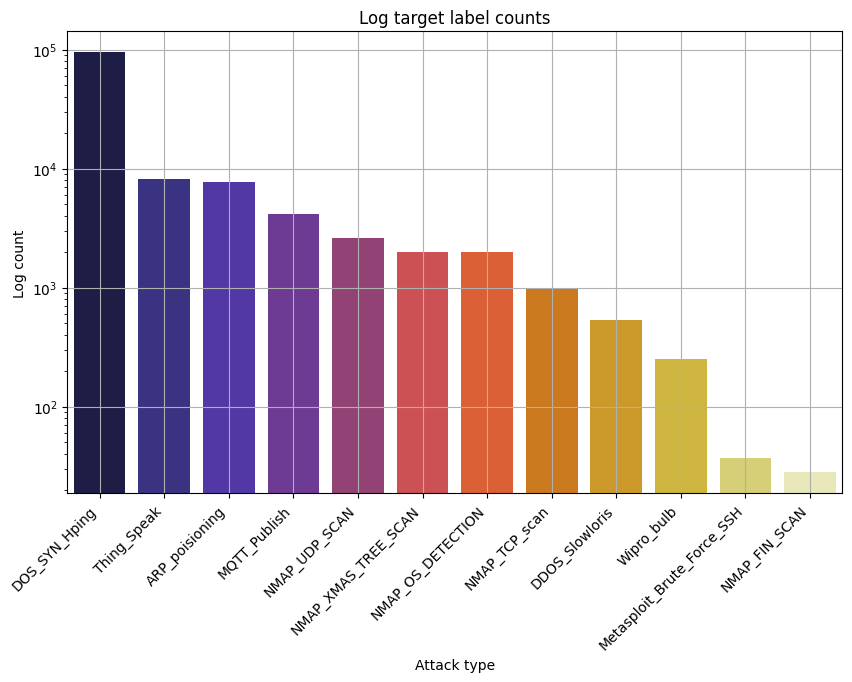

In [5]:
plt.figure(figsize = (10,6))
sns.countplot(data = y, x = y['Attack_type'], order = y['Attack_type'].value_counts().index, palette = 'CMRmap')
plt.yscale('log')
plt.ylabel('Log count')
plt.xlabel('Attack type')
plt.title('Log target label counts')
plt.xticks(rotation = 45, ha = 'right')
plt.grid()
plt.show()

In [6]:
# get counts of protocols
X['proto'].value_counts()

proto
tcp     110427
udp      12633
icmp        57
Name: count, dtype: int64

In [7]:
# get counts of network services
X['service'].value_counts()

service
-         102861
dns         9753
mqtt        4132
http        3464
ssl         2663
ntp          121
dhcp          50
irc           43
ssh           28
radius         2
Name: count, dtype: int64

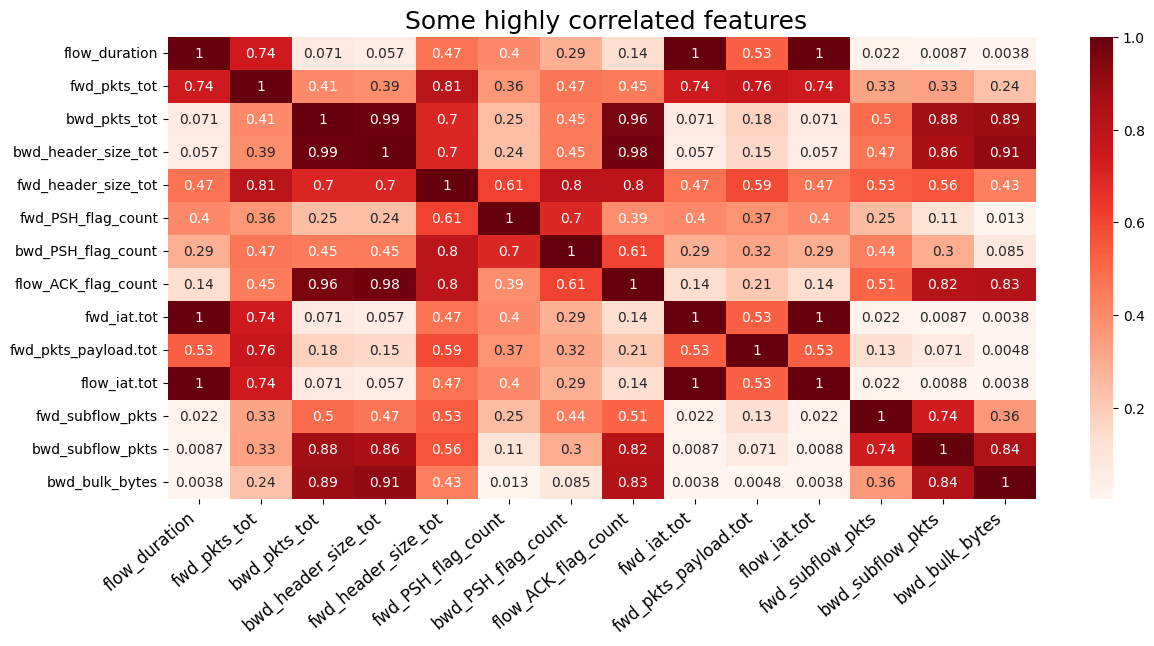

In [10]:
X_filter = X[['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'bwd_header_size_tot', 'fwd_header_size_tot', 'fwd_PSH_flag_count', 
                'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_iat.tot', 'fwd_pkts_payload.tot', 'flow_iat.tot', 'fwd_subflow_pkts', 
                'bwd_subflow_pkts', 'bwd_bulk_bytes']]
X_corr = X_filter.corr()

plt.figure(figsize=(14,6))
sns.heatmap(X_corr, annot = True, cmap = 'Reds')
plt.title(' Some highly correlated features', fontsize = 18)
plt.xticks(rotation = 40, ha = 'right', fontsize = 12)
plt.show()

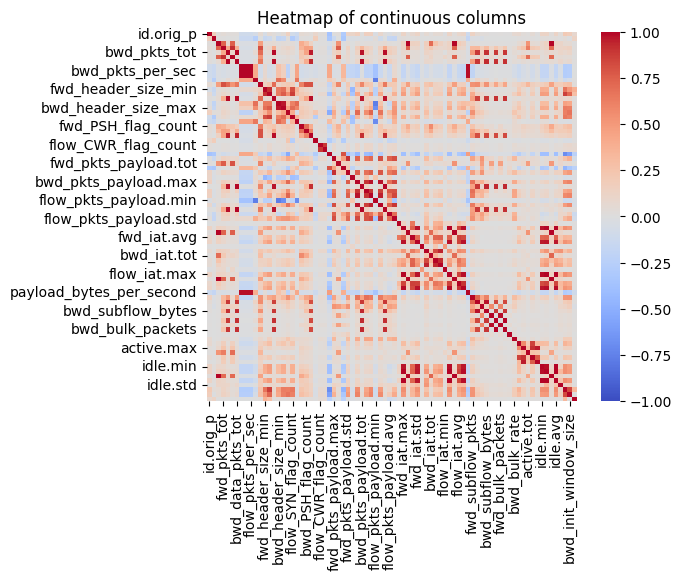

In [33]:
full_corr_matrix = x.drop(["proto", "service", "bwd_URG_flag_count"], axis=1).corr()
sns.heatmap(full_corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True)
plt.title("Heatmap of continuous columns")
plt.show()

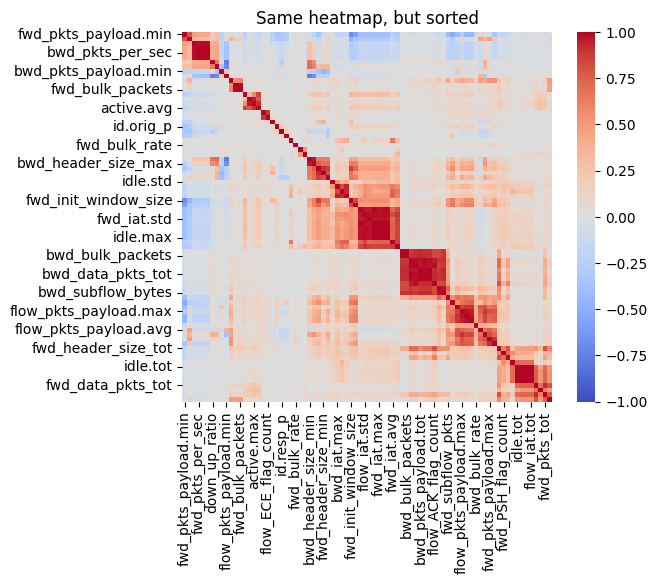

In [17]:
# Use agglomerative clustering on the heatmap
# Result is non-deterministic, so I saved a good value

#from scipy.cluster.hierarchy import linkage, leaves_list
#linkage_matrix = linkage(corr_matrix, method='complete')
#ordered_indices = leaves_list(linkage_matrix)

ordered_indices = np.array([26,29,56,7,8,9,10,19,31,36,59,61,63,67,71,68,70,24,25,79,0,1,23,41,65,46,51,15,16,13,12,18,76,47,49,50,77,78,72,55,45,75,42,52,73,44,54,62,64,4,14,33,6,38,22,58,60,57,17,34,37,32,35,66,39,40,27,30,11,20,21,48,74,43,2,53,5,69,3,28])
ordered_corr_matrix = full_corr_matrix.iloc[ordered_indices, ordered_indices]

sns.heatmap(ordered_corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True)
plt.title("Same heatmap, but sorted")
plt.show()

In [21]:
import plotly.graph_objs as go
import plotly.express as px

fig = px.imshow(np.round(np.abs(ordered_corr_matrix), 2),
                text_auto = True,
                labels = dict(color="Abs(Correlation)"),
                x = ordered_corr_matrix.columns,
                y = corr_matrix.columns,
                color_continuous_scale = "viridis",
                title="Interactive sorted heatmap")

fig.update_traces(hovertemplate="<b>%{x}</b> vs <b>%{y}</b><br>Abs(correlation): %{z:.2f}<extra></extra>")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

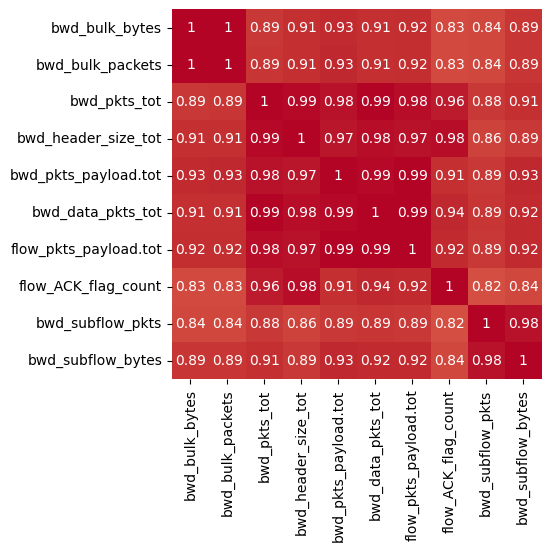

In [30]:
cols = range(47,57)
sub_corr_matrix = ordered_corr_matrix.iloc[cols, cols]
sns.heatmap(sub_corr_matrix, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, annot=True, square=True)
plt.show()

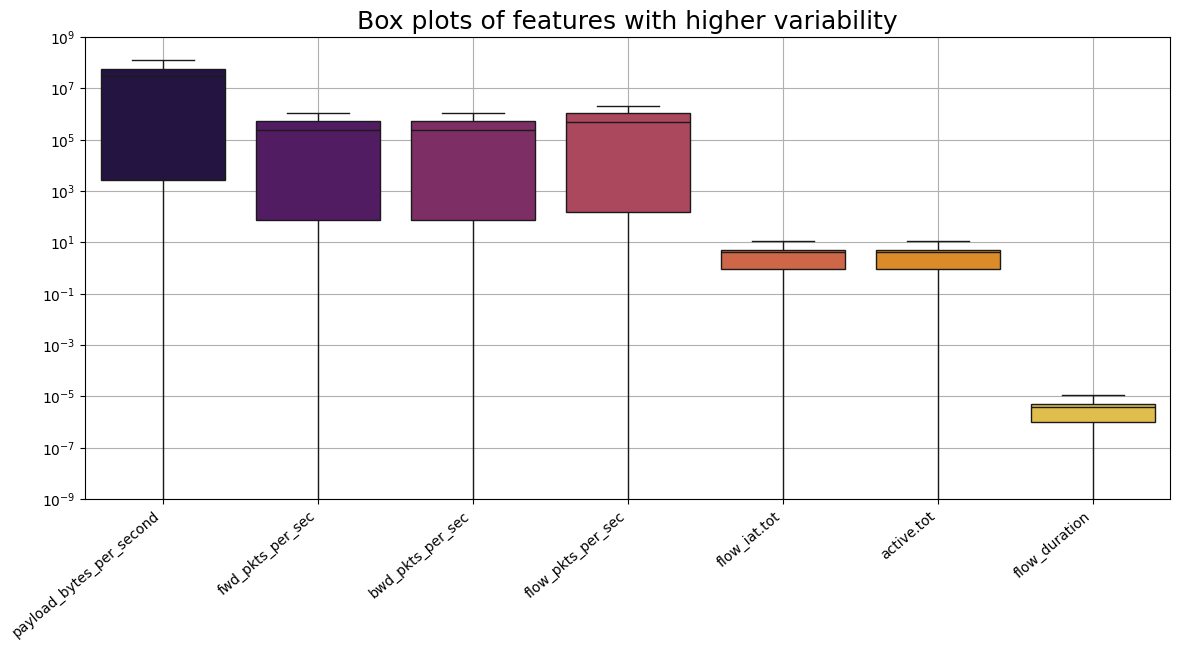

In [23]:
# visualize box plots of features with higher variability
X_higher_variability = X[['payload_bytes_per_second', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'flow_iat.tot', 'active.tot', 'flow_duration']]

plt.figure(figsize = (14,6))
sns.boxplot(data = X_higher_variability, showfliers = False, palette = 'inferno')
plt.yscale('log')
plt.ylim(10**-9, 10**9)
plt.xticks(rotation = 40, ha = 'right')
plt.title('Box plots of features with higher variability', fontsize  = 18)
plt.grid()
plt.show()

/var/folders/h6/jflqd9l57glcp8j75_d60stm0000gn/T/ipykernel_93349/3024510567.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/h6/jflqd9l57glcp8j75_d60stm0000gn/T/ipykernel_93349/3024510567.py:33: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



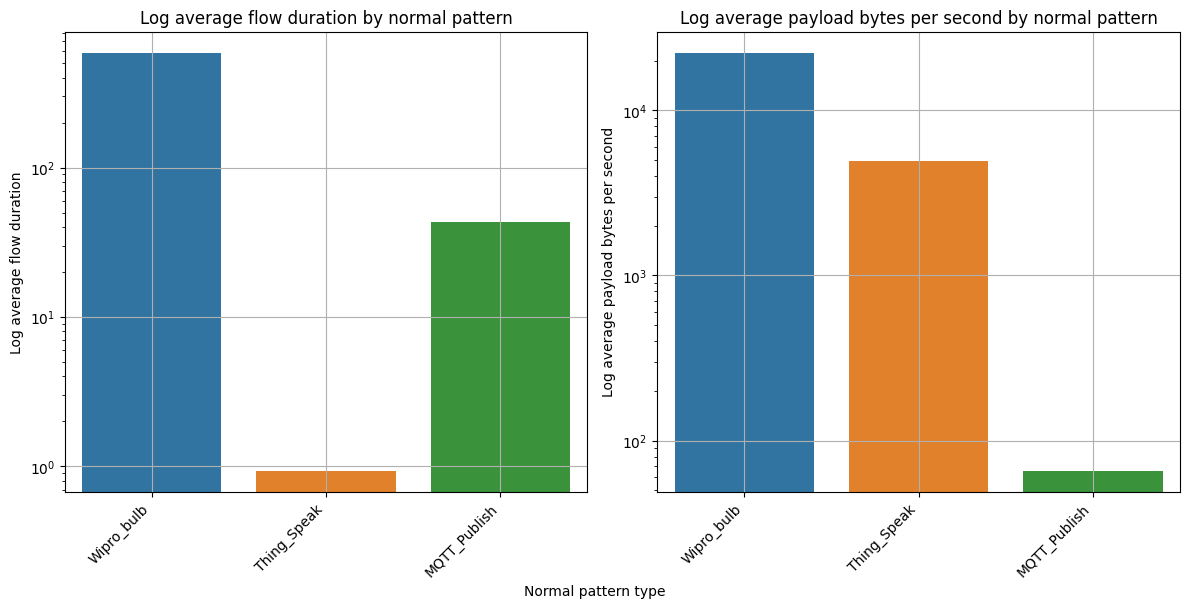

In [38]:
# average flow duration and payload bytes per second for normal patterns
full_data = pd.concat([X,y], axis = 1)

normal_types = [
    'Wipro_bulb',
    'Thing_Speak',
    'MQTT_Publish'
]

fig, axes = plt.subplots(1,2, figsize = (12,6))

for _, normal in enumerate(normal_types):
    normal_patterns = full_data[full_data['Attack_type'] == normal]
    avg_flow_duration = normal_patterns['flow_duration'].mean()
    sns.barplot(x = [normal], y = [avg_flow_duration], ax = axes[0])

axes[0].set_title('Log average flow duration by normal pattern')
axes[0].set_ylabel('Log average flow duration')
axes[0].set_yscale('log')
axes[0].grid()
axes[0].set_xticklabels(normal_types, rotation = 45, ha = 'right')


for _, normal in enumerate(normal_types):
    normal_patterns = full_data[full_data['Attack_type'] == normal]
    avg_payload = normal_patterns['payload_bytes_per_second'].mean()
    sns.barplot(x = [normal], y = [avg_payload], ax = axes[1])

axes[1].set_title('Log average payload bytes per second by normal pattern')
axes[1].set_ylabel('Log average payload bytes per second')
axes[1].set_yscale('log')
axes[1].grid()
axes[1].set_xticklabels(normal_types, rotation = 45, ha = 'right')

fig.text(0.5, -0.001, 'Normal pattern type', ha = 'center')
plt.tight_layout()
plt.show()

/var/folders/h6/jflqd9l57glcp8j75_d60stm0000gn/T/ipykernel_93349/3069576039.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/h6/jflqd9l57glcp8j75_d60stm0000gn/T/ipykernel_93349/3069576039.py:37: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



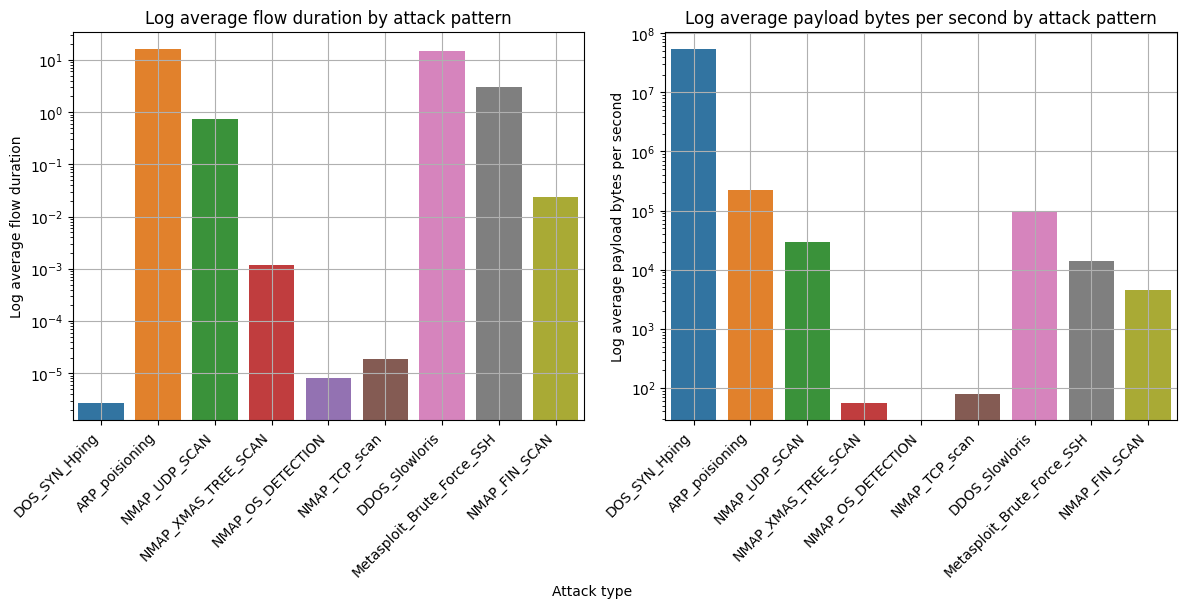

In [34]:
# average flow duration and payload bytes per second for attack patterns
attack_types = [
    'DOS_SYN_Hping',
    'ARP_poisioning',
    'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN',
    'NMAP_OS_DETECTION',
    'NMAP_TCP_scan',
    'DDOS_Slowloris',
    'Metasploit_Brute_Force_SSH',
    'NMAP_FIN_SCAN'
]

fig, axes = plt.subplots(1,2, figsize = (12,6))

for _, attack in enumerate(attack_types):
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_flow_duration = attack_patterns['flow_duration'].mean()
    sns.barplot(x = [attack], y = [avg_flow_duration], ax = axes[0])

axes[0].set_title('Log average flow duration by attack pattern')
axes[0].set_ylabel('Log average flow duration')
axes[0].set_yscale('log')
axes[0].grid()
axes[0].set_xticklabels(attack_types, rotation = 45, ha = 'right')


for _, attack in enumerate(attack_types):
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_payload = attack_patterns['payload_bytes_per_second'].mean()
    sns.barplot(x = [attack], y = [avg_payload], ax = axes[1])

axes[1].set_title('Log average payload bytes per second by attack pattern')
axes[1].set_ylabel('Log average payload bytes per second')
axes[1].set_yscale('log')
axes[1].grid()
axes[1].set_xticklabels(attack_types, rotation = 45, ha = 'right')

fig.text(0.5, -0.001, 'Attack type', ha = 'center')
plt.tight_layout()
plt.show()

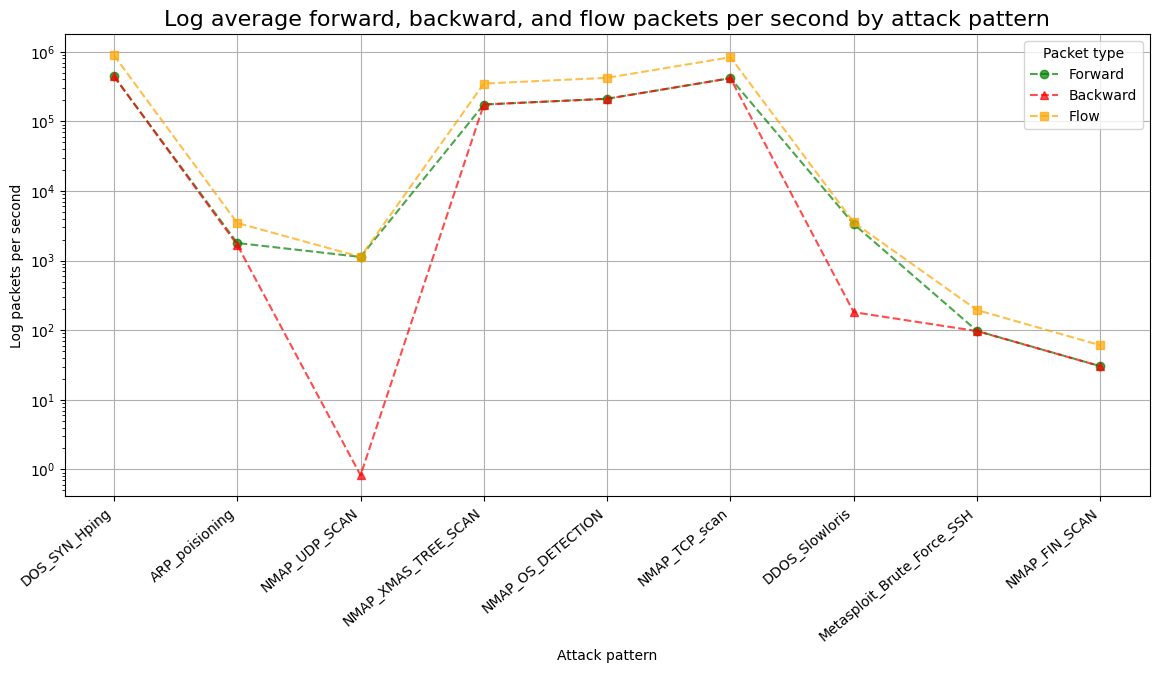

In [41]:
# forward, backward, and flow packets per second by Attack Pattern
fwd = []
bwd = []
flow = []

plt.figure(figsize = (14, 6))

for attack in attack_types:
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_fwd_pkts = attack_patterns['fwd_pkts_per_sec'].mean()
    fwd.append(avg_fwd_pkts)
    avg_bwd_pkts = attack_patterns['bwd_pkts_per_sec'].mean()
    bwd.append(avg_bwd_pkts)
    avg_flow_pkts = attack_patterns['flow_pkts_per_sec'].mean()
    flow.append(avg_flow_pkts)

plt.plot(attack_types, fwd, label = 'Forward',  linestyle = '--', marker = 'o', color = 'green', alpha = 0.7)
plt.plot(attack_types, bwd, label = 'Backward', linestyle = '--', marker = '^', color = 'red', alpha = 0.7)
plt.plot(attack_types, flow, label = 'Flow',  linestyle = '--', marker = 's', color = 'orange', alpha = 0.7)
plt.title('Log average forward, backward, and flow packets per second by attack pattern', fontsize = 16)
plt.xlabel('Attack pattern')
plt.ylabel('Log packets per second')
plt.xticks(rotation = 40, ha = 'right')
plt.legend(title = "Packet type")
plt.grid()
plt.yscale('log')
plt.show()

## Unsupervised VAE 

## Supervised VAE

## Comparing Predictions: Benign vs. Malicious

- Exclude id.orig_p, id_resp_p, ANY OTHERS?
- One-hot encode proto and service ?